<a href="https://colab.research.google.com/github/nipeti/kats/blob/main/time_series_prediction_using_kats_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
# For Google Colab:
#!pip install kats

In [2]:
# https://facebookresearch.github.io/Kats/

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://raw.githubusercontent.com/nipeti/kats/main/ML.txt'
df = pd.read_csv(url, encoding='UTF-8', sep=';', decimal=',')
df = df.drop(['FR0000121261','103.35', '103.95','102.20', '464939'], axis=1) 
df.rename(columns={'103.00': 'Michelin', '16/09/19':'date'}, inplace=True)
df

,date,Michelin
0,17/09/19,101.85
1,18/09/19,102.45
2,19/09/19,103.65
3,20/09/19,102.45
4,23/09/19,101.20
...,...,...
504,06/09/21,137.55
505,07/09/21,138.20
506,08/09/21,136.25
507,09/09/21,136.85


In [3]:
# Turn the stock price into float and the month column into datetime
df['Michelin'] = df.Michelin.astype('float')
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y")

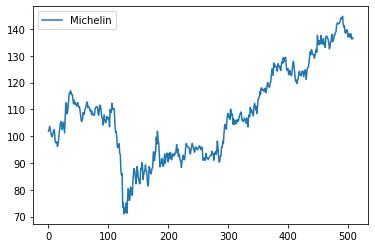

In [4]:
df['Michelin'].plot(legend=True)

In [5]:
# Set date as index
df = df.set_index("date", verify_integrity='True')

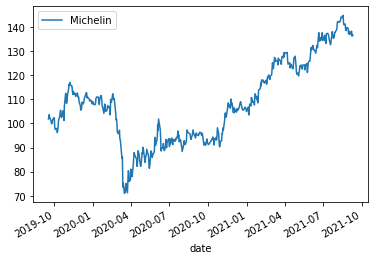

In [6]:
df['Michelin'].plot(legend=True)

In [7]:
Michelin = df["Michelin"].to_frame()
Michelin

,Michelin
date,
2019-09-17,101.85
2019-09-18,102.45
2019-09-19,103.65
2019-09-20,102.45
2019-09-23,101.20
...,...
2021-09-06,137.55
2021-09-07,138.20
2021-09-08,136.25


In [8]:
# Split data into train and test set
train_len = 407 #80/20
train = Michelin.iloc[:train_len]
test = Michelin.iloc[train_len:]

In [9]:
from kats.consts import TimeSeriesData

# Construct TimeSeriesData object
ts = TimeSeriesData(df.reset_index(), time_col_name="date")

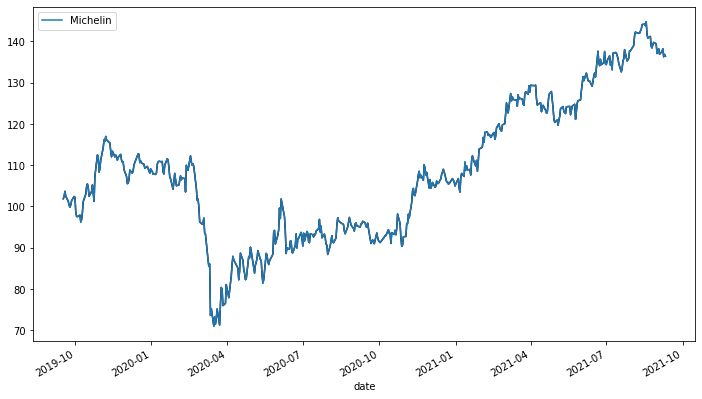

In [10]:
ts.plot(cols=["Michelin"])

In [15]:
from kats.models.prophet import ProphetModel, ProphetParams

# Specify parameters
params = ProphetParams(seasonality_mode="additive")

# Create a model instance
m = ProphetModel(ts, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=120, freq="D")
fcst

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,time,fcst,fcst_lower,fcst_upper
0,2021-09-11,141.256603,136.097853,146.269255
1,2021-09-12,141.369948,135.884262,146.694161
2,2021-09-13,141.902478,136.593732,147.683458
3,2021-09-14,142.151628,136.508112,147.501796
4,2021-09-15,142.191857,136.553555,147.588044
...,...,...,...,...
115,2022-01-04,154.846201,143.591218,168.088447
116,2022-01-05,154.886430,143.791044,168.338600
117,2022-01-06,154.699637,143.041996,167.504790
118,2022-01-07,155.011742,143.235678,169.485574


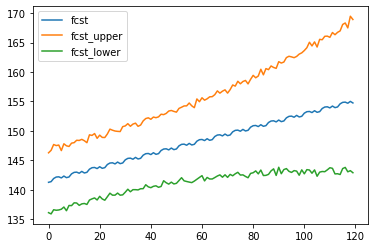

In [16]:
fcst['fcst'].plot(legend= True)
fcst['fcst_upper'].plot(legend= True)
fcst['fcst_lower'].plot(legend= True)

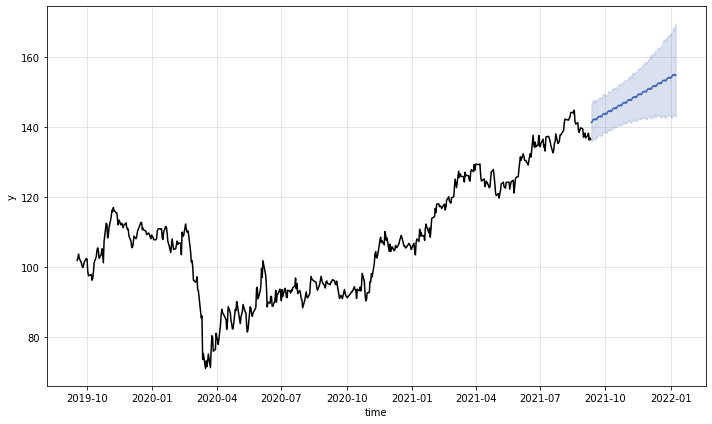

In [17]:
m.plot()

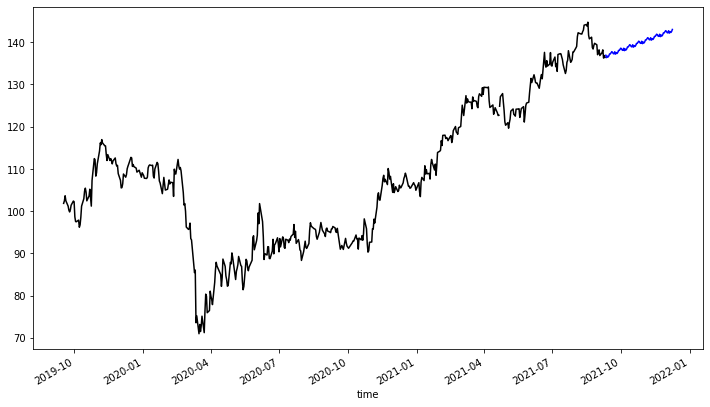

In [47]:
fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label="train", color="black")
test.plot(ax=ax, label="test", color="black")
fcst.plot(x="time", y="fcst", ax=ax, color="blue")

#ax.fill_between(test.index, fcst["fcst_lower"], fcst["fcst_upper"], alpha=0.5)
ax.get_legend().remove()

In [31]:
#API of all models : https://facebookresearch.github.io/Kats/api/kats.models.html

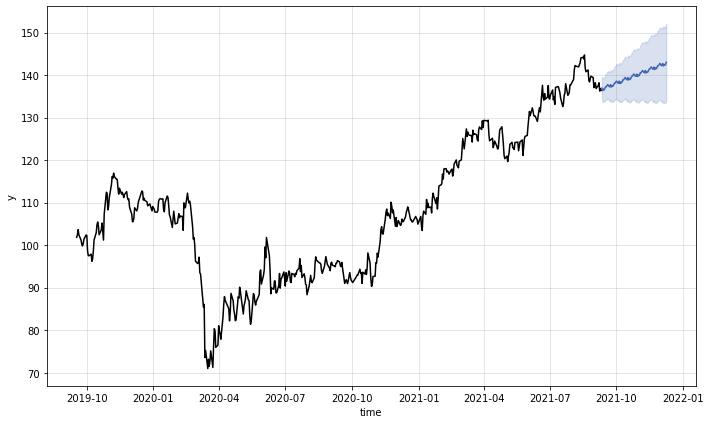

In [37]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
import warnings
warnings.simplefilter(action='ignore')

params = HoltWintersParams(
            trend="add",
            seasonal="add",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=ts, 
    params=params)

m.fit()
fcst = m.predict(steps=90, alpha = 0.2)
m.plot()

The change point is on 2021-01-29 00:00:00


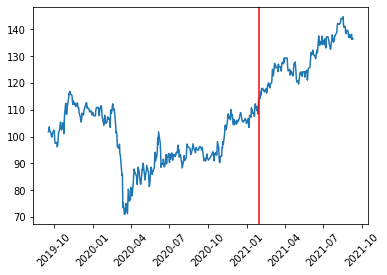

In [20]:
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

detector = CUSUMDetector(ts)

change_points = detector.detector(change_directions=["increase", "decrease"])
print("The change point is on", change_points[0][0].start_time)

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [21]:
def get_ts(topic: str):
    return TimeSeriesData(df[topic].to_frame().reset_index(), time_col_name="date")

def detect_change_point(topic: str):
    ts = get_ts(topic)
    detector = CUSUMDetector(ts)

    change_points = detector.detector()
    for change_point in change_points:
        print("The change point is on", change_point[0].start_time)

    # plot the results
    plt.xticks(rotation=45)
    detector.plot(change_points)
    plt.show()

The change point is on 2021-01-29 00:00:00


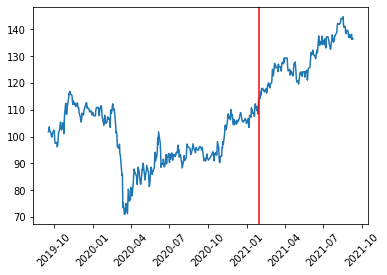

In [22]:
detect_change_point("Michelin")

In [35]:
from kats.detectors.outlier import OutlierDetector

# Get time series object
ts = get_ts("Michelin")

# Detect outliers
ts_outlierDetection = OutlierDetector(ts, "additive")
ts_outlierDetection.detector()

# Print outliers
outlier_range1 = ts_outlierDetection.outliers[0]
outlier_range1

[Timestamp('2020-03-12 00:00:00', freq='D')]

In [27]:
from kats.tsfeatures.tsfeatures import TsFeatures

model = TsFeatures()

output_features = model.transform(ts)
output_features

{'binarize_mean': 0.4636542239685658,
 'crossing_points': 18,
 'diff1y_acf1': -0.05866028733292596,
 'diff1y_acf5': 0.012712329253653395,
 'diff1y_pacf5': 0.013116186427593022,
 'diff2y_acf1': -0.5128569948690883,
 'diff2y_acf5': 0.2699261732113686,
 'diff2y_pacf5': 0.5631004405447175,
 'entropy': 0.2058581290869226,
 'firstmin_ac': 230,
 'firstzero_ac': 146,
 'flat_spots': 2,
 'heterogeneity': 493.4529927810243,
 'histogram_mode': 93.111,
 'holt_alpha': 0.9364522776103309,
 'holt_beta': 2.6390964947462554e-13,
 'hurst': 0.49579734969287453,
 'hw_alpha': 0.9999999850988385,
 'hw_beta': 7.191488134562116e-16,
 'hw_gamma': 3.852438075252563e-09,
 'length': 509,
 'level_shift_idx': 106,
 'level_shift_size': 2.0634999999999906,
 'linearity': 0.44986840544172346,
 'lumpiness': 96.32977816335445,
 'mean': 108.23198428290758,
 'peak': 3,
 'seas_acf1': 0.9396901163686149,
 'seas_pacf1': -0.022758877125459945,
 'seasonality_strength': 0.3589678278851193,
 'spikiness': 2.5297501475387625e-05,
 '

In [38]:
#Awesome!